In [25]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import csv

YOUTUBE_API_KEY = ""Your API Key"


In [60]:
def get_youtube_comments(video_id, max_comments=100):
    youtube = build('youtube', 'v3', developerKey=YOUTUBE_API_KEY)
    comments_data = []
    
    try:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100
        )
        response = request.execute()

        for item in response.get("items", []):
            comment = item["snippet"]["topLevelComment"]["snippet"]
            comments_data.append({
                "video_id": video_id,
                "comment": comment["textDisplay"],
                "author": comment["authorDisplayName"],
                "published_at": comment["publishedAt"],
                "like_count": comment["likeCount"]
            })
            if len(comments_data) >= max_comments:
                break
    
    except HttpError as e:
        print(f"Error fetching comments for Video ID {video_id}: {e}")
    
    return comments_data


In [61]:
# Collect comments for multiple trailers
video_ids = ["Way9Dexny3w", "73_1biulkYk", "RFLLuoBCM9I", "77vRyWNqZjM", "3x77q40hATw"]
all_comments = []
for video_id in video_ids:
    print(f"Extracting comments for Video ID: {video_id}...")
    all_comments.extend(get_youtube_comments(video_id))


Extracting comments for Video ID: Way9Dexny3w...
Extracting comments for Video ID: 73_1biulkYk...
Extracting comments for Video ID: RFLLuoBCM9I...
Extracting comments for Video ID: 77vRyWNqZjM...
Extracting comments for Video ID: 3x77q40hATw...


In [62]:
df = pd.DataFrame(all_comments)
df.to_csv("raw_comments.csv", index=False)


In [63]:
data=pd.read_csv("raw_comments.csv")
data

,video_id,comment,author,published_at,like_count
0,Way9Dexny3w,I have started this movie at 11:40 am today,@electramaze1,2025-02-13T20:17:10Z,0
1,Way9Dexny3w,"<a href=""https://www.youtube.com/watch?v=Way9D...",@T05H18A1037,2025-02-13T10:46:14Z,0
2,Way9Dexny3w,Part 3...can&#39;t wait!!!!!!!!,@svenheimes2494,2025-02-11T20:16:57Z,1
3,Way9Dexny3w,"Wasn&#39;t happy. It killed 3 hours, but that...",@merlinambrosius2554,2025-02-09T02:16:44Z,0
4,Way9Dexny3w,chani so tuff,@YTBennettfn,2025-02-08T19:21:43Z,0
...,...,...,...,...,...
468,3x77q40hATw,"<a href=""https://www.youtube.com/watch?v=M4HhE...",@RKyoutubervillagevlogs-777,2025-02-10T06:41:30Z,0
469,3x77q40hATw,"Acting super hai hero ki., but. Hero hi villan...",@Raahe-deen786,2025-02-10T04:24:38Z,0
470,3x77q40hATw,Nice picture follow me help,@SanjayGiri-f5j,2025-02-10T03:16:53Z,0
471,3x77q40hATw,Bakwas movie,@HamaraBharat-k8i,2025-02-10T00:14:21Z,0


In [64]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.lower().strip()
    return text

df['cleaned_comment'] = df['comment'].apply(clean_text)
df.dropna(subset=['cleaned_comment'], inplace=True)


In [65]:
df.to_csv("cleaned_comments.csv", index=False)


In [66]:
df['comment_length'] = df['cleaned_comment'].apply(lambda x: len(x.split()))
df['contains_emoji'] = df['comment'].apply(lambda x: any(char in x for char in ['😀', '😂', '❤️', '🔥', '😭']))
df['word_count'] = df['cleaned_comment'].apply(lambda x: len(x.split()))


In [67]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Download VADER Lexicon
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Function to ensure input is a valid string
def safe_text(text):
    if isinstance(text, float) or pd.isna(text):  # Handle NaN and non-string values
        return ""
    return str(text)

# Function to get sentiment using VADER
def get_vader_sentiment(comment):
    comment = safe_text(comment)  # Convert to string
    score = sia.polarity_scores(comment)["compound"]
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

# Function to get sentiment using TextBlob
def get_textblob_sentiment(comment):
    comment = safe_text(comment)  # Convert to string
    polarity = TextBlob(comment).sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

# Load cleaned dataset
df = pd.read_csv("cleaned_comments.csv")

# Ensure 'cleaned_comment' column exists
if "cleaned_comment" in df.columns:
    df["vader_sentiment"] = df["cleaned_comment"].apply(get_vader_sentiment)
    df["textblob_sentiment"] = df["cleaned_comment"].apply(get_textblob_sentiment)
    df.to_csv("sentiment_analysis_results.csv", index=False)
    print("✅ Sentiment analysis completed and saved to 'sentiment_analysis_results.csv'")
else:
    print("❌ Error: 'cleaned_comment' column not found in the dataset. Check your preprocessing steps.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


✅ Sentiment analysis completed and saved to 'sentiment_analysis_results.csv'


In [69]:

# Compare VADER vs. TextBlob
df["agreement"] = df["vader_sentiment"] == df["textblob_sentiment"]

# Calculate agreement percentage
agreement_rate = df["agreement"].mean() * 100


In [70]:

# Print results
print(f"\nVADER vs. TextBlob Agreement Rate: {agreement_rate:.2f}%")
print("\nSample Sentiment Predictions:")
print(df[["cleaned_comment", "vader_sentiment", "textblob_sentiment"]].head(10))



VADER vs. TextBlob Agreement Rate: 80.34%

Sample Sentiment Predictions:
                                     cleaned_comment vader_sentiment  \
0         i have started this movie at 1140 am today         neutral   
1  141  149 epic piece of music shame its not on ...        negative   
2                                  part 3can39t wait         neutral   
3    wasn39t happy  it killed 3 hours but that39s it        negative   
4                                      chani so tuff         neutral   
5  we don39t need oscars to get to the green para...         neutral   
6  not immersive long boring sets are unimpressiv...        positive   
7  dune has set a high bar for scifi blockbusters...        positive   
8                                    still here 2025         neutral   
9                      best movie of the year period        positive   

  textblob_sentiment  
0            neutral  
1           positive  
2            neutral  
3           positive  
4            neutr

C:\Users\Admin\AppData\Local\Temp\ipykernel_13244\402145586.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='coolwarm')


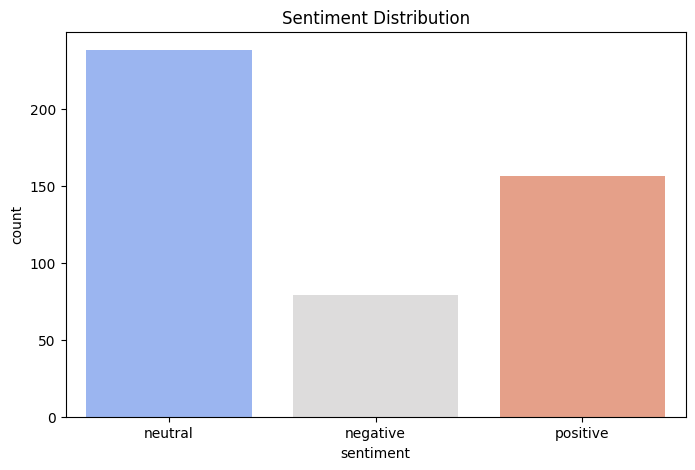

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='sentiment', palette='coolwarm')
plt.title('Sentiment Distribution')
plt.show()


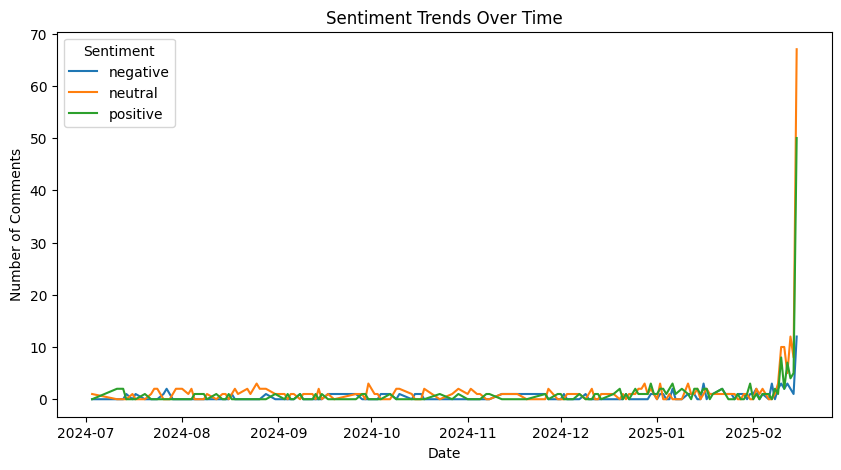

In [14]:
df["published_at"] = pd.to_datetime(df["published_at"])  # Convert to datetime

# Group by Date
sentiment_trend = df.groupby(df["published_at"].dt.date)["sentiment"].value_counts().unstack().fillna(0)

# Plot Trends
sentiment_trend.plot(kind="line", figsize=(10,5))
plt.title("Sentiment Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.legend(title="Sentiment")
plt.show()


In [16]:
top_movies = df.groupby('video_id')['sentiment'].value_counts().unstack(fill_value=0)
top_movies['positive_ratio'] = top_movies['positive'] / (top_movies['positive'] + top_movies['negative'] + top_movies['neutral'])
top_movies = top_movies.sort_values(by='positive_ratio', ascending=False)

print("Top Ranked Movies by Positive Sentiment:")
print(top_movies[['positive_ratio']])


Top Ranked Movies by Positive Sentiment:
sentiment    positive_ratio
video_id                   
3x77q40hATw        0.480000
Way9Dexny3w        0.380000
73_1biulkYk        0.370000
77vRyWNqZjM        0.250000
RFLLuoBCM9I        0.109589
